<a href="https://colab.research.google.com/github/angiellanos/Merton_con_procesos_difusi-n_con_saltos/blob/main/Modelos_de_Merton_con_saltos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MODELOS DE MERTON CON PROCESOS DE DIFUSIÓN CON SALTOS**
## **Universidad Nacional de Colombia**
# Derivados de Renta Variable
---
Elaborado por:
###Angie Eloisa Llanos
---



# 1. **Introducción**

Este modelo financiero avanzado para la valoración de opciones integra procesos de Poisson y movimiento Browniano para capturar con mayor precisión las fluctuaciones extremas del mercado. A diferencia de los modelos tradicionales, este enfoque aborda las anomalías estadísticas como sesgo y exceso de curtosis en los rendimientos. Utilizamos datos históricos del índice MSCI COLCAP, que incluye algunas de las acciones más representativas del mercado colombiano, del período del **28 de junio del 2019** al **27 de junio de 2024**. El objetivo es calcular el precio de una opción europea de compra sobre este índice, explorando varios precios de ejercicio (strikes) y tiempos de madurez. Esta metodología mejora la gestión de riesgos financieros y la evaluación se realizará con un enfoque empírico, ofreciendo una perspectiva más realista del comportamiento de los activos en mercados emergentes.



# 2. **Objetivo General:**

Diseñar la valoración de una opción call europea sobre el índice MSCI COLCAP con una madurez de 1 año, utilizando modelos de Merton estocásticos que consideran tanto movimientos continuos como discontinuidades en forma de saltos.

# 3. **Descripción de los datos**

In [1]:
import warnings, random
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm, shapiro, poisson as poiss
from numpy.random import poisson, normal
from math import exp,sqrt,log,factorial
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import interp1d

# Historia de precios MSCI COLCAP:

# URL 1 AÑO:
# url = 'https://raw.githubusercontent.com/angiellanos/Merton_con_procesos_difusi-n_con_saltos/main/MSCI_COLCAP_20240615_1A.csv'

# URL 3 AÑOS:
# url = 'https://raw.githubusercontent.com/angiellanos/Merton_con_procesos_difusi-n_con_saltos/main/MSCI_COLCAP_20240615_3A.csv'

# URL 5 AÑOS:
url = 'https://raw.githubusercontent.com/angiellanos/Merton_con_procesos_difusi-n_con_saltos/main/MSCI_COLCAP_20240628_5A.csv'

data = pd.read_csv(url, delimiter=';')
print(data.head())

        Fecha Valor hoy Valor ayer  Variación absoluta Variación porcentual  \
0  28/06/2019  1,548.98   1,547.69                1.29                0.08%   
1   2/07/2019  1,543.76   1,548.98               -5.22               -0.34%   
2   3/07/2019  1,563.72   1,543.76               19.96                1.29%   
3   4/07/2019  1,565.96   1,563.72                2.24                0.14%   
4   5/07/2019  1,579.19   1,565.96               13.23                0.84%   

   Variación 12 meses  Variación año  
0               -1.77          16.82  
1               -1.12          16.42  
2               -0.45          17.93  
3               -0.06          18.10  
4                1.38          19.10  


Como se va a utilizar únicamente los precios del índice se toma el dataframe solo con la columna de precios y se genera la columna de los rendimientos.

In [2]:
data = data.iloc[:, :2]

data['Valor hoy'] = data['Valor hoy'].replace(',', '', regex=True).astype(float)
data['Retornos'] = np.log(data['Valor hoy'] / data['Valor hoy'].shift(1))

# volver la columna Fecha a la columna de índices y el nombre de la columna Valor hoy cambie ese nombre a Precios
data = data.set_index('Fecha').rename(columns={'Valor hoy': 'Precios'})
data.index = pd.to_datetime(data.index)

print(data.head())

            Precios  Retornos
Fecha                        
2019-06-28  1548.98       NaN
2019-07-02  1543.76 -0.003376
2019-07-03  1563.72  0.012847
2019-07-04  1565.96  0.001431
2019-07-05  1579.19  0.008413


In [3]:
print(f"La cantidad de retornos diarios considerados son referentes a {len(data)} días de valoración")

La cantidad de retornos diarios considerados son referentes a 1220 días de valoración




---


### Comportamiento del precio diario del índice MSCI COLCAP

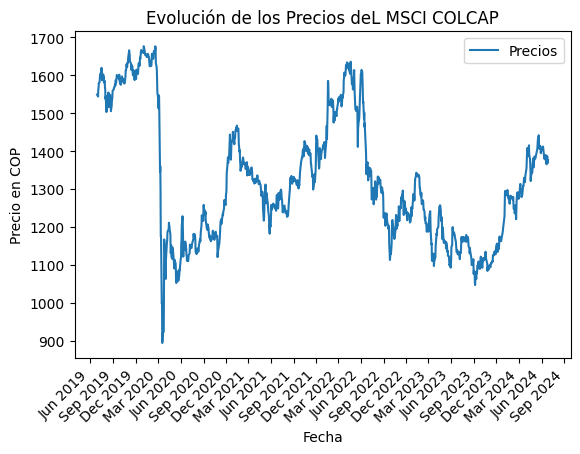

In [4]:
ax = data.plot(y='Precios')
ax.set_title('Evolución de los Precios deL MSCI COLCAP')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio en COP')

# Configurar el formato de las fechas
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Etiquetas cada 6 meses
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato mes y año

plt.xticks(rotation=45)
plt.show()

Se observa una tendencia general al alza con varias fluctuaciones significativas en el camino. Este tipo de tendencia es típico en mercados que están experimentando un crecimiento o recuperación, pero también muestra volatilidad, indicando cambios potencialmente significativos en las condiciones del mercado o respuestas a eventos económicos externos. Estas fluctuaciones brindan un escenario ideal para la implementación del modelo, ya que este puede ajustarse para reflejar no solo las tendencias de crecimiento sino también los saltos significativos que no siguen una distribución normal.




---



### Rendimientos logarítmicos diarios deL MSCI COLCAP

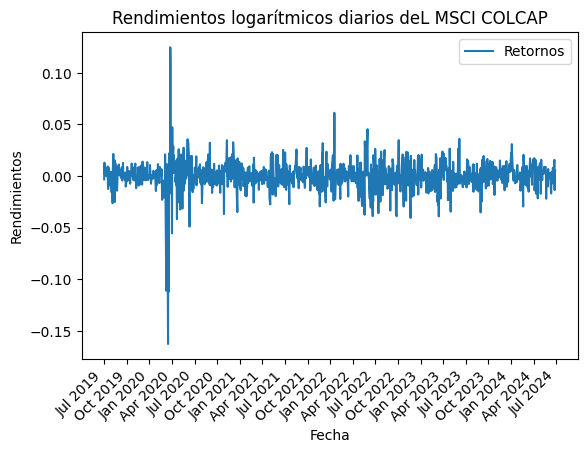

In [5]:
def returns(df):
  ax = df.plot(y='Retornos')
  ax.set_title('Rendimientos logarítmicos diarios deL MSCI COLCAP')
  ax.set_xlabel('Fecha')
  ax.set_ylabel('Rendimientos')

  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Etiquetas cada 6 meses
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato mes y año

  plt.xticks(rotation=45)
  plt.show()

returns(data)

Estos rendimientos logarítmicos diarios oscilan alrededor de cero con algunos picos significativos en ambas direcciones. Estos picos indican días con movimientos de precios anormalmente altos o bajos, posiblemente debidos a noticias del mercado o cambios económicos.



---

### Distribución empírica normalizada del rendimiento logarítmico diario del índice MSCI COLCAP y la distribución normal.

In [6]:
# Borrar el primer elemento que da nulo, y comprobar que solo elimine ese
print(len(data))
data = data.dropna()
print(len(data))
print(data.head())

1220
1219
            Precios  Retornos
Fecha                        
2019-07-02  1543.76 -0.003376
2019-07-03  1563.72  0.012847
2019-07-04  1565.96  0.001431
2019-07-05  1579.19  0.008413
2019-07-08  1581.08  0.001196


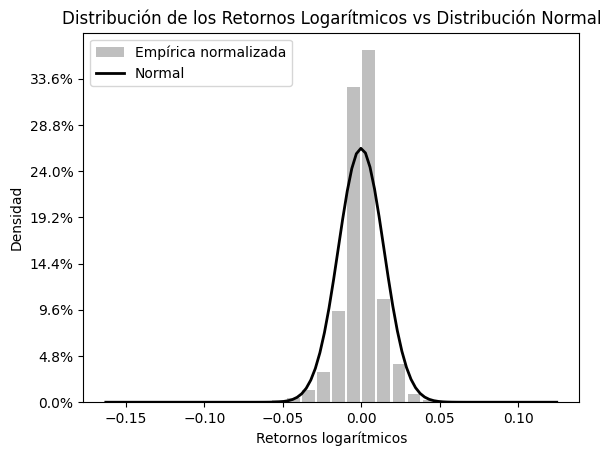

In [7]:
def histograma(df):
  # Histograma de los retornos logarítmicos
  counts, bins, patches = plt.hist(df['Retornos'], bins=30, density=True, alpha=0.5, color='grey', label='Empírica normalizada', rwidth=0.85)

  # Calcular la media y desviación estándar de los retornos logarítmicos
  mu, std = norm.fit(df['Retornos'])

  # Crear un rango de valores que cubre todas las barras del histograma
  x = np.linspace(bins[0], bins[-1], 100)

  # Calcular la distribución normal con la media y desviación estándar calculadas
  p = norm.pdf(x, mu, std)

  # Graficar la distribución normal
  plt.plot(x, p, 'k', linewidth=2, label='Normal')

  # Ajustar las etiquetas del eje Y para mostrar porcentajes
  bin_widths = np.diff(bins)
  y_vals = plt.gca().get_yticks()
  new_labels = ['{:.1%}'.format(y * bin_widths.mean()) for y in y_vals]
  plt.gca().set_yticklabels(new_labels)

  # Añadir etiquetas y leyenda
  plt.title('Distribución de los Retornos Logarítmicos vs Distribución Normal')
  plt.xlabel('Retornos logarítmicos')
  plt.ylabel('Densidad')
  plt.legend()
  plt.show()

  return mu, std

mu, std = histograma(data)

Se observa que la distribución empírica exhibe una cresta más marcada y colas más pesadas en comparación con la distribución normal estándar. Esto sugiere que los rendimientos del índice experimentan variaciones más extremas que las esperadas bajo la suposición de normalidad.



---

### Gráfica Q - Q del rendimiento logarítmico diario del índice MSCI COLCAP

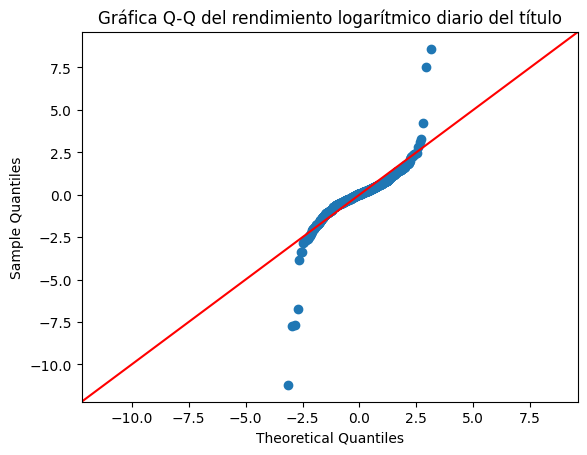

In [8]:
def qqplot(df):
  sm.qqplot(df['Retornos'], line ='45', fit=True)
  plt.title('Gráfica Q-Q del rendimiento logarítmico diario del título')
  plt.show()

qqplot(data)

Esta gráfica refuerza rendimientos no normales al proporcionar una visualización directa de cómo los cuantiles de los datos reales se desvían de aquellos esperados bajo una distribución normal. En particular, los extremos de la gráfica muestran una desviación significativa de la línea teórica, lo que indica la presencia de colas más pesadas. Estas desviaciones son críticas ya que sugieren que eventos extremos son más probables de lo que la distribución normal puede predecir, un aspecto importante a considerar en la gestión de riesgos y en la modelación financiera.



---

### Diferencia entre la distribución acumulada de los rendimientos logarítmicos diarios del índice MSCI COLCAP y la distribución normal estándar.

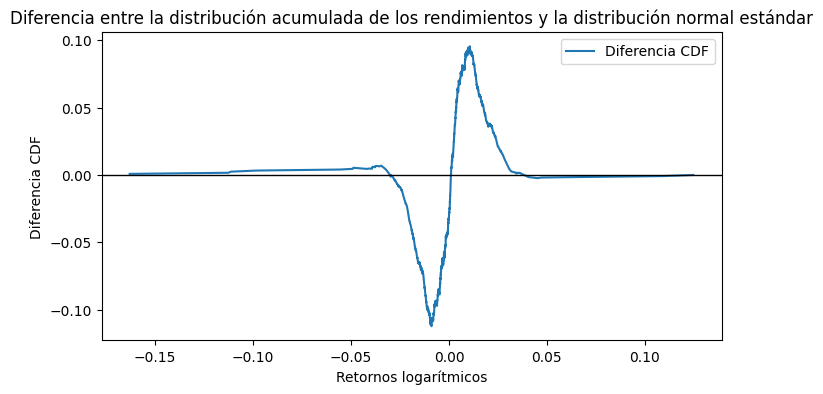

In [9]:
def diferencia(df):
  # Ordena los datos y calcula su CDF empírico
  sorted_data = np.sort(df['Retornos'])
  cdf_empirical = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

  # Calcula el CDF de una distribución normal estándar con la misma media y desviación estándar que los datos
  norm_cdf = norm.cdf(sorted_data, np.mean(sorted_data), np.std(sorted_data))

  # Diferencia entre el CDF empírico y el CDF teórico
  diff_cdf = cdf_empirical - norm_cdf

  # Graficar la diferencia
  plt.figure(figsize=(8, 4))
  plt.plot(sorted_data, diff_cdf, label='Diferencia CDF')
  plt.axhline(0, color='black', linewidth=1)
  plt.title('Diferencia entre la distribución acumulada de los rendimientos y la distribución normal estándar')
  plt.xlabel('Retornos logarítmicos')
  plt.ylabel('Diferencia CDF')
  plt.legend()
  plt.show()

diferencia(data)

Se observa una variabilidad considerable alrededor del origen y desviaciones a lo largo de todo el rango de los datos. Esto corrobora que los rendimientos del MSCI COLCAP no siguen una distribución normal, implicando que el uso de modelos estándar basados en supuestos de normalidad podría no ser adecuado.

In [10]:
def prueba_normalidad(df):
  stat, p = shapiro(df['Retornos'])
  nsig = 0.001
  print("\n\n Prueba de normalidad Shapiro-Wilk")
  print('Estadístico:', stat)
  print('p-valor:', p, '   Proviene de dist. normal' if p>nsig else '   No proviene de dist. normal')

prueba_normalidad(data)



 Prueba de normalidad Shapiro-Wilk
Estadístico: 0.8106043338775635
p-valor: 1.4872860482790227e-35    No proviene de dist. normal


# 4. **Modelamiento**

Para la valoración de la opción de compra, se utiliza el modelo de saltos de Merton, extendido del modelo Black-Scholes, que incorpora tanto un proceso de difusión continua como saltos discretos para capturar mejor las fluctuaciones extremas en los precios de mercado. La dinámica del índice MSCI COLCAP se modela según la siguiente ecuación estocástica:

$$
dS_t = S_t (\mu dt + \sigma dW_t + \nu dN_t) \ \ \ \ \ \ \ \ \small{(1)}
$$

donde:

  * $dS_t$: Representa el cambio diferencial en el precio del índice en el tiempo $t$.
  * $S_t$: Es el precio del índice en el tiempo $t$.
  * $\mu$: La tasa de retorno esperada del índice.
  * $dt$: El incremento infinitesimal en el tiempo.
  * $\sigma$: La volatilidad de los retornos del índice.
  * $dW_t$: Incremento del movimiento Browniano, que aporta la componente de difusión.
  * $\nu$: La magnitud del salto.
  * $dN_t$: Incremento en el proceso de Poisson que cuenta el número de saltos.

Parámetros Estadísticos para $\mu$, $\sigma$ y λ:

  * $\mu$ y $\sigma$: Se calculan usando datos históricos del índice excluyendo los días que experimentaron saltos. Para este análisis, se considera la media y volatilidad de los retornos del último año para proporcionar una aproximación relevante para el siguiente año.

  Además, veamos un análisis preliminar para saber si z = 1.4 desviaciones describen los retornos cercanos a una distribución normal
  

In [11]:
z = 1.4
print(mu - z * std, mu + z * std)


-0.020430945257597213 0.020237424499371853


In [12]:
filtered_data = data[(data['Retornos'].between(mu - z * std, mu + z *std))]
lim_inf = min(filtered_data.Retornos)
lim_sup = max(filtered_data.Retornos)
print("Días normales:  ", len(filtered_data), "    return min: ",lim_inf, "  max: ",lim_sup )
outliers_data = data[(~data['Retornos'].between(mu - z * std, mu + z * std))]
lambda_2023 = len(outliers_data)
print("Días con saltos:  ", lambda_2023, "    return min: ", min(outliers_data.Retornos),  "  max: ", max(outliers_data.Retornos))

print("\n\n Parte del DF días normales:\n",filtered_data.head(10))
print("\n\n Parte del DF días con saltos:\n",outliers_data.head(10))
print("\n\n Saltos más altos:\n",outliers_data.sort_values(by='Retornos', ascending=False).head(5))
print("\n\n Saltos más bajos:\n",outliers_data.sort_values(by='Retornos', ascending=True).head(5))

Días normales:   1107     return min:  -0.020150328408479523   max:  0.02016609077854676
Días con saltos:   112     return min:  -0.1629032089172267   max:  0.12469742972745629


 Parte del DF días normales:
             Precios  Retornos
Fecha                        
2019-07-02  1543.76 -0.003376
2019-07-03  1563.72  0.012847
2019-07-04  1565.96  0.001431
2019-07-05  1579.19  0.008413
2019-07-08  1581.08  0.001196
2019-07-09  1588.90  0.004934
2019-07-10  1600.91  0.007530
2019-07-11  1600.50 -0.000256
2019-07-12  1605.15  0.002901
2019-07-15  1605.01 -0.000087


 Parte del DF días con saltos:
             Precios  Retornos
Fecha                        
2019-08-05  1503.00 -0.026512
2019-08-08  1545.44  0.021327
2019-08-14  1515.80 -0.025268
2020-02-21  1631.45 -0.023115
2020-02-27  1556.69 -0.021009
2020-03-04  1544.53  0.020883
2020-03-06  1502.84 -0.028741
2020-03-09  1344.60 -0.111260
2020-03-11  1295.46 -0.048773
2020-03-12  1174.31 -0.098185


 Saltos más altos:
             Pre



---

### Análisis con z desviaciones

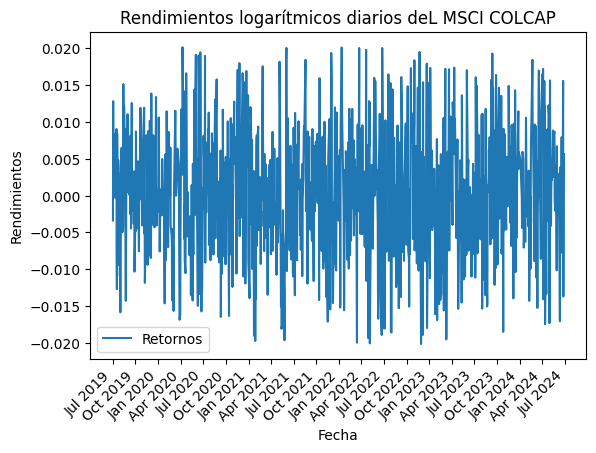

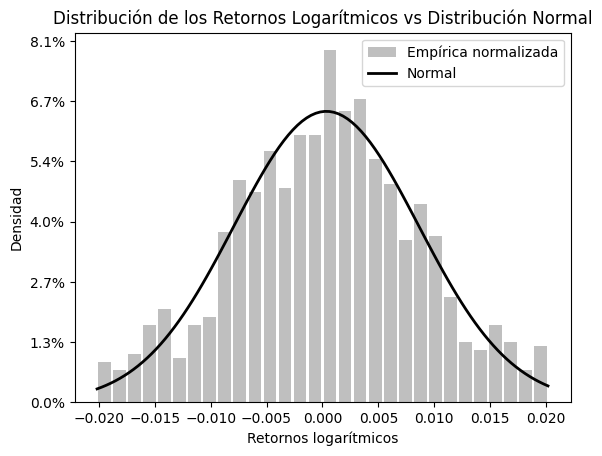

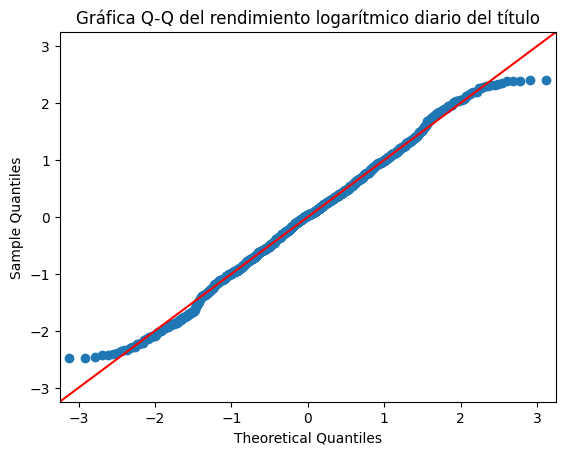

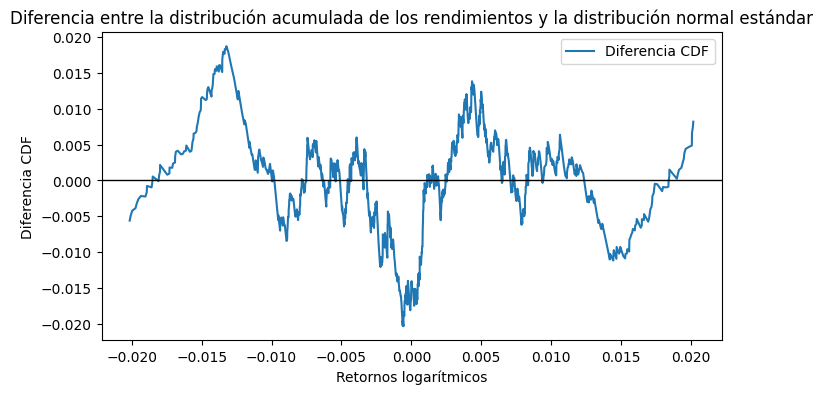



 Prueba de normalidad Shapiro-Wilk
Estadístico: 0.9951593279838562
p-valor: 0.0013250461779534817    Proviene de dist. normal


In [13]:
returns(filtered_data)
mu_ss, std_ss = histograma(filtered_data)
qqplot(filtered_data)
diferencia(filtered_data)
prueba_normalidad(filtered_data)



---



In [14]:
new_mu = filtered_data['Retornos'].mean()
new_std = filtered_data['Retornos'].std()
print(new_mu, new_std)

0.00035146062688204877 0.008258974479428154


  * Saltos y λ: Los saltos se definen como movimientos en el índice que exceden z desviaciones estándar de los retornos diarios. Utilizando datos de los últimos cinco años, se calcula la cantidad media anual de estos saltos para establecer λ.


In [15]:
def lambda_anual(df, year):
  # Select rows from data where the index is between year-06-28 and year+1-06-27 and the Retornos value is between mu-z*std and mu+z*std
  jump_filtered_data = df[(df.index >= f'{year}-06-28') & (df.index <= f'{year+1}-06-27')]
  lambda_ = len(jump_filtered_data)
  print(jump_filtered_data.head(10),"\n\n")
  v_mean = abs(jump_filtered_data['Retornos']).mean()
  v_std = abs(jump_filtered_data['Retornos']).std()
  return jump_filtered_data, lambda_, v_mean, v_std

jump_filtered_data_2019_2020, lambda_2019, v_mean_2019, v_std_2019 = lambda_anual(outliers_data, 2019)
jump_filtered_data_2020_2021, lambda_2020, v_mean_2020, v_std_2020 = lambda_anual(outliers_data, 2020)
jump_filtered_data_2021_2022, lambda_2021, v_mean_2021, v_std_2021 = lambda_anual(outliers_data, 2021)
jump_filtered_data_2022_2023, lambda_2022, v_mean_2022, v_std_2022 = lambda_anual(outliers_data, 2022)
jump_filtered_data_2023_2024, lambda_2023, v_mean_2023, v_std_2023 = lambda_anual(outliers_data, 2023)

# Print the number of rows for each filtered data set
print("Días con saltos 2019-2020: ", lambda_2019, " Promedio longitud del salto: ", v_mean_2019, "  y desviación: ", v_std_2019)
print("Días con saltos 2020-2021: ", lambda_2020, " Promedio longitud del salto: ", v_mean_2020, " y desviación: ", v_std_2020)
print("Días con saltos 2021-2022: ", lambda_2021, " Promedio longitud del salto: ", v_mean_2021, " y desviación: ", v_std_2021)
print("Días con saltos 2022-2023: ", lambda_2022, " Promedio longitud del salto: ", v_mean_2022, " y desviación: ", v_std_2022)
print("Días con saltos 2023-2024: ", lambda_2023, "  Promedio longitud del salto: ", v_mean_2023, " y desviación: ", v_std_2023)

lambda_mean = (lambda_2019 + lambda_2020 + lambda_2021 + lambda_2022 + lambda_2023) / 5
print("\nlambda_mean: ", lambda_mean)
lambda_mean = round(lambda_mean,0)
print("\nlambda_mean entero: ", lambda_mean)

v_mean = abs(outliers_data.Retornos).mean()
v_std = outliers_data.Retornos.std()
print("\nSalto promedio: ", v_mean, "\nStd promedio: ",v_std)


            Precios  Retornos
Fecha                        
2019-08-05  1503.00 -0.026512
2019-08-08  1545.44  0.021327
2019-08-14  1515.80 -0.025268
2020-02-21  1631.45 -0.023115
2020-02-27  1556.69 -0.021009
2020-03-04  1544.53  0.020883
2020-03-06  1502.84 -0.028741
2020-03-09  1344.60 -0.111260
2020-03-11  1295.46 -0.048773
2020-03-12  1174.31 -0.098185 


            Precios  Retornos
Fecha                        
2020-07-31  1134.34 -0.026378
2020-08-25  1230.56  0.020840
2020-09-01  1255.76  0.032150
2020-10-28  1120.37 -0.036983
2020-11-09  1213.69  0.034664
2020-12-01  1285.12  0.021329
2020-12-04  1341.23  0.032662
2020-12-21  1377.38 -0.035020
2021-02-25  1335.79 -0.025835
2021-04-30  1250.65 -0.021633 


            Precios  Retornos
Fecha                        
2021-07-02  1289.38  0.022716
2021-07-19  1238.12 -0.027382
2021-08-17  1301.69  0.025600
2021-09-27  1345.40  0.027138
2021-11-19  1298.64 -0.029500
2021-11-29  1347.45  0.021863
2021-12-01  1418.24  0.031807
2021

  * Rango de $\nu$: El valor de $\nu$ se establece entre z desviaciones estándar por encima y por debajo de la media, reflejando los movimientos extremos hacia arriba y hacia abajo respectivamente.

Este modelo permite capturar tanto las fluctuaciones ordinarias del mercado como eventos extremos, proporcionando una herramienta más robusta para la gestión de riesgos y la planificación estratégica en mercados financieros volátiles.

## Ejemplo del libro:

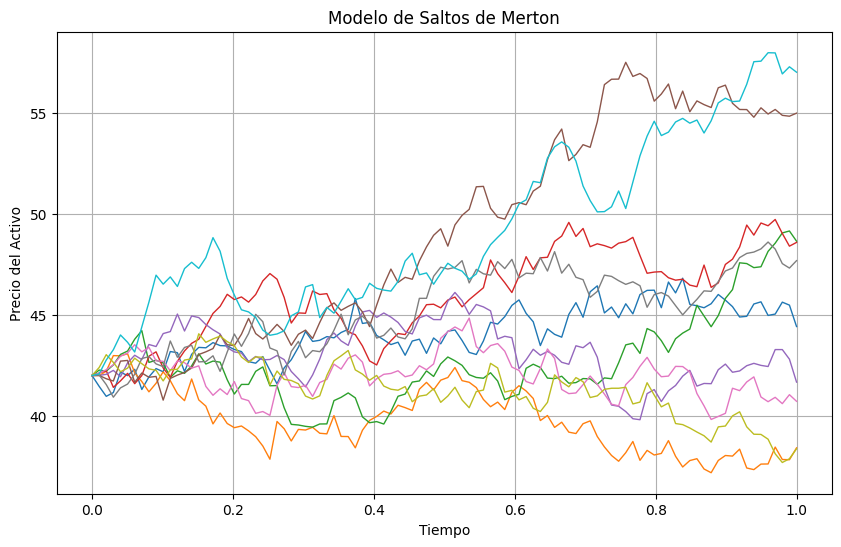

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del modelo
S0 = 42      # Precio inicial
r = 0.11     # Tasa libre de riesgo
sigma = 0.13 # Volatilidad sin saltos
lmbda = 0.1  # Intensidad de los saltos
mu = 0.01    # Media sin saltos
delta = 0.2  # Desviación estándar de los saltos
T = 1.0      # Tiempo final
N = 100      # Número de pasos en la discretización temporal
M = 10       # Número de trayectorias a simular

dt = T / N   # Tamaño del paso temporal

# Función para simular una trayectoria del proceso de Merton con saltos
def simulate_merton_jump_process(S0, r, sigma, lmbda, mu, delta, T, N):
    dt = T / N
    S = np.zeros(N)
    S[0] = S0
    for t in range(1, N):
        # Simulación del movimiento browniano
        Wt = np.random.normal(0, np.sqrt(dt))
        # Simulación del número de saltos
        Nt = np.random.poisson(lmbda * dt)
        # Simulación del tamaño de los saltos
        Jt = np.random.normal(mu, delta) if Nt > 0 else 0
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * Wt + Jt)
    return S

# Simulación de M trayectorias
trajectories = np.zeros((M, N))
for i in range(M):
    trajectories[i] = simulate_merton_jump_process(S0, r, sigma, lmbda, mu, delta, T, N)

# Gráfica de las trayectorias
time_grid = np.linspace(0, T, N)
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(time_grid, trajectories[i], lw=1)
plt.title('Modelo de Saltos de Merton')
plt.xlabel('Tiempo')
plt.ylabel('Precio del Activo')
plt.grid(True)
plt.show()


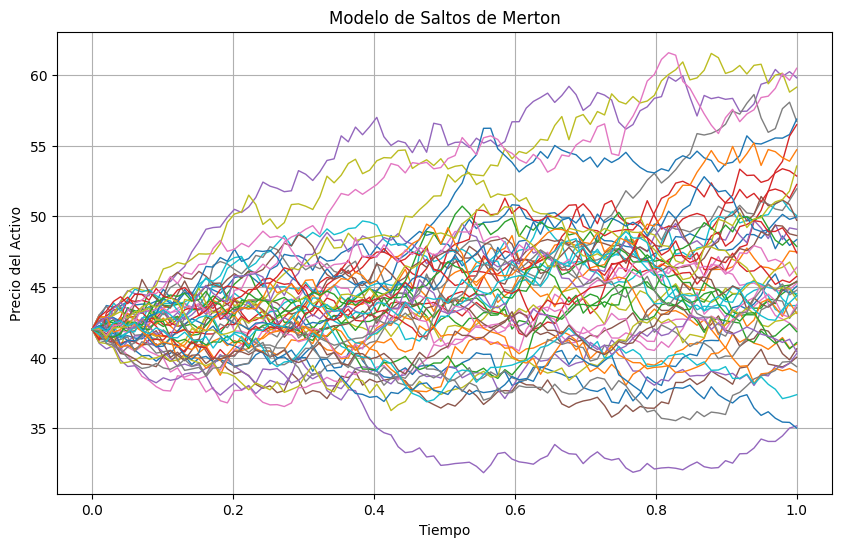

In [20]:
M = 50  # Número de trayectorias a simular

# Simulación de M trayectorias
trajectories = np.zeros((M, N))
for i in range(M):
    trajectories[i] = simulate_merton_jump_process(S0, r, sigma, lmbda, mu, delta, T, N)

# Gráfica de las trayectorias
time_grid = np.linspace(0, T, N)
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(time_grid, trajectories[i], lw=1)
plt.title('Modelo de Saltos de Merton')
plt.xlabel('Tiempo')
plt.ylabel('Precio del Activo')
plt.grid(True)
plt.show()


# Fórmula de Merton para valuación de opciones

En el modelo de Merton con saltos, la evaluación de opciones se extiende para incorporar discontinuidades en el precio del subyacente, representadas por un proceso de Poisson. Esto permite capturar eventos extremos del mercado que los modelos de difusión continua como Black-Scholes no pueden describir eficazmente. Bajo este marco, el valor del portafolio se ajusta no solo por los cambios estándar en el precio del subyacente guiados por un movimiento Browniano, sino también por saltos repentinos.

\\

El cambio en el tiempo de un portafolio está dado por:
$$
d\Pi_t^{(\Delta)} = \left( \frac{\partial c}{\partial t} + \frac{1}{2} \sigma^2 S_t^2 \frac{\partial^2 c}{\partial S_t^2} \right) dt + \left( c(S_t(1 + \nu), t) - c(S_t, t) - \nu S_t \frac{\partial c}{\partial S_t} \right) dN_t    \ \ \ \ \ \ \ \ \small{(2)}
$$

donde Δ hace referencia a la cobertura dada por 1 opción de precio $c(S_t,t)$ y $-∂c/∂S_t$ títulos accionarios de precio $S_t$. Tomando la esperana de $\small{(2)}$, a fin de evitar oportunidades de arbitraje libres de riesgo, se tiene:

$$
E[d\Pi_t^{(r)}] = E[d\Pi_t^{(r)}|S_t] = r \left( c(S_t, t) - \frac{\partial c}{\partial S_t} S_t \right) dt    \ \ \ \ \ \ \ \ \small{(3)}
$$

Además utiliando que $E[d\Pi_t^{(Δ)}] =E_v[E[d\Pi_t^{(Δ)}]] $, se llega a:

$$
\frac{\partial c}{\partial t} + \frac{1}{2} \sigma^2 S_t^2 \frac{\partial^2 c}{\partial S^2} + rS_t \frac{\partial c}{\partial S_t} - rc + \lambda \mathbb{E}_v \left[ c(S_t (1 + \nu), t) - c(S_t, t) \right] - \lambda S_t \frac{\partial c}{\partial S} \mathbb{E}_v[\nu] = 0    \ \ \ \ \ \ \ \ \small{(4)}
$$

Con las condiciones de frontera $c(0,t)=0$ y $c(S_t, t)=\max(S_t-K,0)$, donde $K$ es el precio de ejercicio de la opción.

\\

* Una posibilidad para determinar $c(S_t ,t)$ , a partir de $\small{(4)}$, consiste en definir una sucesión de variables aleatorias $Y_n$ que tienen la misma distribución que el producto de $n$ variables independientes e idénticamente distribuidas a $v + 1$, definiendo $Y_0 = 1$. Es decir, si $\{v_n\}_{n∈\mathbf{N}}$ es una sucesión de variables aleatorias independientes idénticamente distribuidas a $v$. Se definen:

  $$
  Y_0 = 1
  $$
  $$
  Y_1 = v_1 + 1
  $$
  $$
  Y_2 = (v_1 + 1)(v_2 + 1)
  $$
  $$
  \vdots
  $$
  $$
  Y_n = \prod_{k=1}^n(v_k+1)
  $$
  $$
  \vdots
  $$

  Obteniendo así la solución:

  $$
  c(S_t, t) = \sum_{n=0}^{\infty} e^{-\lambda (T-t)} \frac{(\lambda (T-t))^n}{n!} \mathbb{E}_{Y_n} \left[ c_{BS}(S_t Y_n e^{-\lambda E_\nu[v] (T-t)}, t; \sigma^2, r) \right]    \ \ \ \ \ \ \ \ \small{(5)}
  $$

  donde $c_{BS} (*)$ es la solución básica de Black-Scholes. La ecuación anterior proporciona un valor medio, $c(S_t,t)$ , de las primas esperadas, $E_{Y_n}[c_{BS} (*) ]$ , con respecto a una distribución de Poisson con media $λ(T-t)$.





In [ ]:
# Parámetros del modelo
S0 = data['Precios'].iloc[-1]  # Precio inicial del índice
print(f"El precio actual del índice S_0 es: {S0}")

T = 1.0       # Tiempo hasta la madurez (en años)
t = 0.0       # Tiempo actual
tau = T - t   # Tiempo de madurez
new_mu        # Tasa de retorno esperada sin saltos
new_std       # Volatilidad del subyacente sin saltos
Yn = [1]      # Variables aleatorias
N = 100       # Número de trayectorias simuladas
v_mean        # Media de los saltos
v_std         # Desviación estándar de los saltos
Ev2 = abs(outliers_data.Retornos**2).mean()       # Segundo momento de de los saltos

# Parámetros variables para medir sensibilidad
lambda_values = [lambda_2023, lambda_mean, lambda_2022]   # Tasa de llegada de saltos (3-5 años)
# K_values = [1400, 1425, 1450]        # Precio de ejercicio
K_values = range(1350, 1451)        # Precio de ejercicio
r_values = [0.04, 0.045, 0.05]      # Tasa libre de riesgo


El precio actual del índice S_0 es: 1376.64



   Ahora para determinar $c(S_t ,t)$, supongamos que el tamaño del salto es lognormal, es decir, $Y=\ln(X-a)\sim N(\nu,\delta^2)$, $X > a$, entonces $X = a + e^Y$. La función de densidad de $X$ satisface

  $$
  f_X(x) =
  \begin{cases}
  \frac{1}{\sqrt{2\pi }\delta(x-a)} \exp \left( -\frac{(\ln(x-a) - \nu)^2}{2\delta^2} \right) & \text{si } x > a, \\
  0 & \text{si } x \leq a.
  \end{cases}
  $$

  En este caso,

  $$
  E_X[X] = a + e^{\nu + \frac{\delta^2}{2}}, \quad E_X[\ln(X - a)] = \nu,
  $$
  $$
  \text{Var}_X[X] = e^{2\nu+\delta^2}(e^{\delta^2} - 1) \ \ \ \ \ \ \ \ y \ \ \ \quad \text{Var}_X[\ln(X - a)] = \delta^2.
  $$

  En el caso particular de que $\nu$ tenga distribución lognormal con media $-1 + e^{\gamma}$, es decir,

  $$
  1 + E_\nu[\nu] = e^\gamma, \ \ \ \ \ \ \ \ ó \ \ \ \quad \gamma = \ln(1 + E_\nu[\nu]),
  $$

  y si

  $$
  \text{Var}_\nu[\ln(\nu + 1)] = \delta^2,
  $$

  entonces $Y_n$ se distribuye también lognormal con $E_{Y_n}[Y_n] = e^{n \gamma} = \exp\left(n \ln(1 + E_\nu[\nu])\right)$ y $\text{Var}_\nu[\ln(Y_n)] = n \delta^2$, entonces el precio de la opción está dado por

  $$
  c(S_t,t;T) = \sum_{n=0}^{\infty} e^{-\lambda'(T-t)} \frac{(\lambda' (T - t))^n}{n!} c_{BS}(S_t,t;\sigma_n^2,r_n,T),
  $$

  donde,

  $$
  \lambda' = \lambda (1 + E_\nu[\nu]),
  $$
  $$
  \sigma_n^2 = \sigma^2 + \frac{n \delta^2}{ T - t},
  $$
  $$
  r_n = r - \lambda E_\nu[\nu] +\frac{ n \ln(1 + E_\nu[\nu])}{ T - t}
  $$



     Strike  Lambda  Risk-Free Rate  Merton Option Price  B-S Option Price
0      1350     9.0           0.040                79.61             79.57
1      1350     9.0           0.045                86.07             86.04
2      1350     9.0           0.050                92.50             92.48
3      1350    22.0           0.040                79.68             79.57
4      1350    22.0           0.045                86.13             86.04
..      ...     ...             ...                  ...               ...
904    1450    22.0           0.045                 4.63              1.28
905    1450    22.0           0.050                 6.15              3.34
906    1450    32.0           0.040                 5.38              0.38
907    1450    32.0           0.045                 6.15              1.28
908    1450    32.0           0.050                 7.47              3.34

[909 rows x 5 columns]


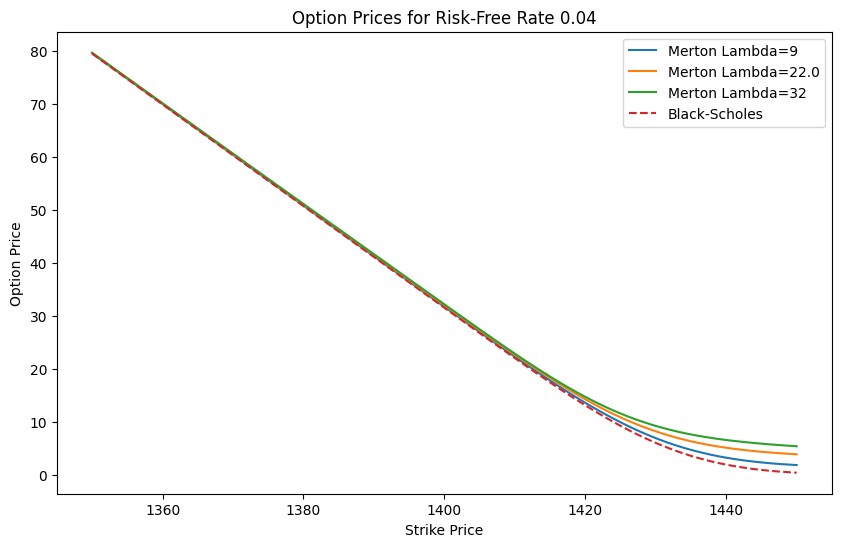

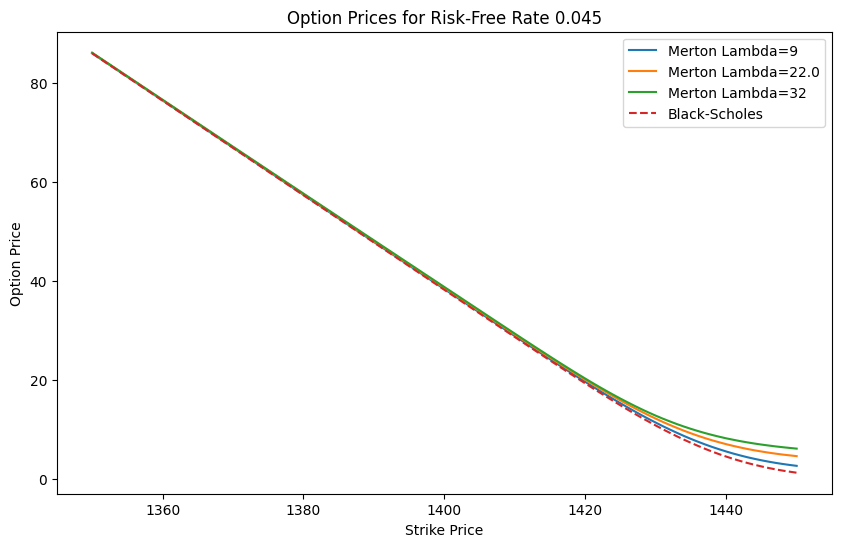

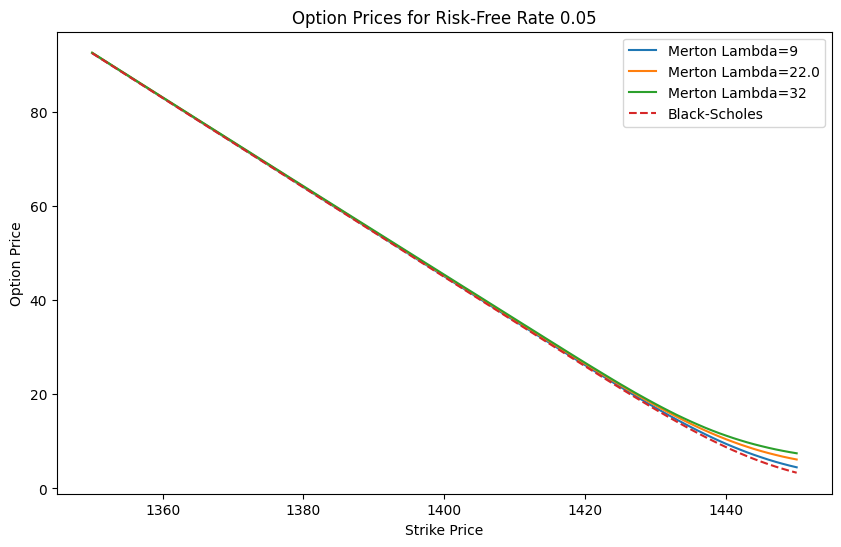

In [ ]:
# Función para la fórmula de Black-Scholes para una opción de compra europea sin dividendos
def black_scholes_call(S, K, tau, r, sigma):
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * sqrt(tau))
    d2 = d1 - sigma * sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

def black_scholes_s_log(S, K, tau, lambda_, n, d, r, sigma):
    d2 = (log(S / K) - lambda_ * v_mean * tau + n * log(1 + v_mean) + r * tau) / sqrt((sigma**2 + n * d**2 /tau) * tau)
    d1 = d2 + sqrt((sigma**2 + n * d**2 /tau) * tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)


def merton_jump_call(S, K, r, sigma, lambda_, delta, n_terms=N):
    # Parámetros ajustados
    lambda_prime = lambda_ * (1 + v_mean)
    r_prime = r - lambda_ * v_mean

    # Calculo del precio de la opción
    price = 0
    for n in range(n_terms):
        jump_prob = poiss.pmf(n, lambda_prime * tau)   # Probabilidad de n saltos
        r_n = r_prime + (n * log(1 + v_mean) / tau)
        sigma_n = sqrt(sigma ** 2 + (n * delta ** 2) / tau)
        price += jump_prob * black_scholes_s_log(S, K, tau, lambda_, n, delta, r_n, sigma_n)
    return price


resultsln = []

for K in K_values:
    for lambda_m in lambda_values:
        for r in r_values:
            price = merton_jump_call(S0, K, r, new_std, lambda_m/250, v_std)
            bs_price = black_scholes_call(S0, K, tau, r, new_std)
            resultsln.append({'Strike': K, 'Lambda': lambda_m, 'Risk-Free Rate': r, 'Merton Option Price': round(price,2), 'B-S Option Price': round(bs_price, 2)})

# Convert resultsln to DataFrame
df_resultsln = pd.DataFrame(resultsln)
print(df_resultsln)

# Graficar los resultados
for r in r_values:
    plt.figure(figsize=(10, 6))
    for lambda_m in lambda_values:
        subset = df_resultsln[(df_resultsln['Risk-Free Rate'] == r) & (df_resultsln['Lambda'] == lambda_m)]
        plt.plot(subset['Strike'], subset['Merton Option Price'], label=f'Merton Lambda={lambda_m}')
    plt.plot(subset['Strike'], subset['B-S Option Price'], linestyle='--', label=f'Black-Scholes')

    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title(f'Option Prices for Risk-Free Rate {r}')
    plt.legend()
    plt.show()

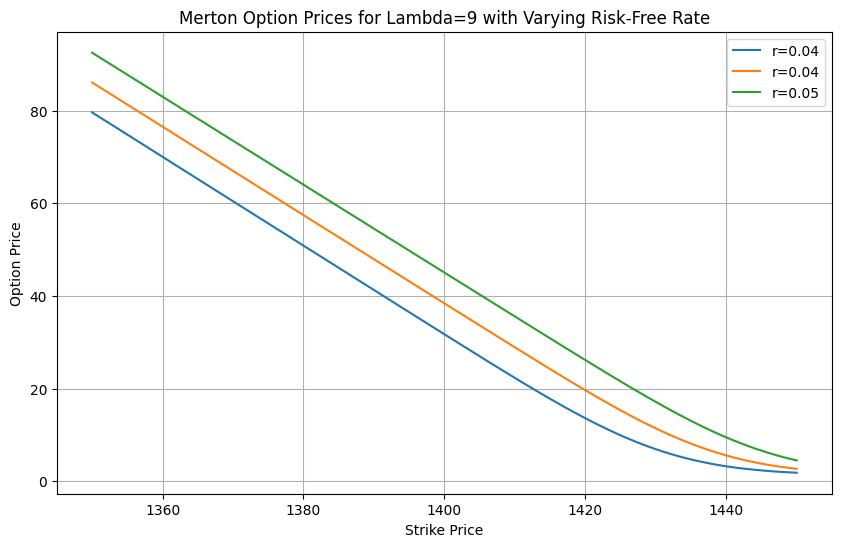

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponemos que df_resultsln ya existe y contiene los datos necesarios
# Debes asegurarte de que 'Lambda' y 'Risk-Free Rate' estén correctamente definidos en el DataFrame

lambda_fixed = lambda_values[0]  # El valor de lambda que queremos fijar

# Crear una figura para la gráfica
plt.figure(figsize=(10, 6))

# Filtrar por lambda específico y graficar para cada tasa de interés
for r in r_values:
    subset = df_resultsln[(df_resultsln['Lambda'] == lambda_fixed) & (df_resultsln['Risk-Free Rate'] == r)]
    plt.plot(subset['Strike'], subset['Merton Option Price'], label=f'r={r:.2f}')

# Detalles del gráfico
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title(f'Merton Option Prices for Lambda={lambda_fixed} with Varying Risk-Free Rate')
plt.legend()
plt.grid(True)  # Opcional, añade una cuadrícula para mejor visualización
plt.show()


Para Strike = 1350, r = 0.04 y lambda = 9


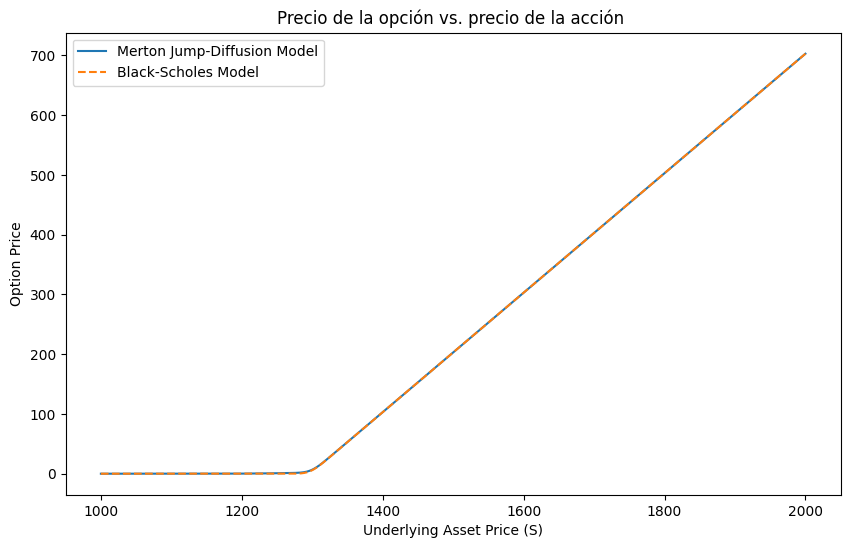

In [ ]:
# Graficar el precio de la opción respecto del precio del activo subyacente
S_values = np.linspace(1000, 2000, 1000)  # Rango de precios del activo subyacente
merton_prices = []
bs_prices = []

print(f"Para Strike = {K_values[0]}, r = {r_values[0]} y lambda = {lambda_values[0]}")

for S in S_values:
    merton_price = merton_jump_call(S, K_values[0], r_values[0], new_std, lambda_values[0]/250, v_std)
    bs_price = black_scholes_call(S, K_values[0], tau, r_values[0], new_std)
    merton_prices.append(merton_price)
    bs_prices.append(bs_price)

plt.figure(figsize=(10, 6))
plt.plot(S_values, merton_prices, label='Merton Jump-Diffusion Model')
plt.plot(S_values, bs_prices, linestyle='--', label='Black-Scholes Model')
plt.xlabel('Underlying Asset Price (S)')
plt.ylabel('Option Price')
plt.title('Precio de la opción vs. precio de la acción ')
plt.legend()
plt.show()

